In [6]:

import os

import numpy as np
import pandas as pd
import joblib
import cloudpickle
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from scipy.stats import ks_2samp

In [13]:

# ---------------- CONFIG ----------------
figs_folder = '../artifacts'
os.makedirs(figs_folder, exist_ok=True)

saved_folder = 'classification_package'

MODEL_PATH = os.path.join(saved_folder,"model.pkl")
PREPROCESSOR_PATH = os.path.join(saved_folder,"preprocessor.pkl")
REFERENCE_DATA_PATH = os.path.join(saved_folder,"X_rest.pkl")  
REFERENCE_TARGET_PATH = os.path.join(saved_folder,"Y_rest.pkl")  
UNSEEN_DATA_PATH = os.path.join(saved_folder,"X_test.pkl")
UNSEEN_TARGET_PATH = os.path.join(saved_folder,"Y_test.pkl")


# Load
with open(PREPROCESSOR_PATH, 'rb') as f:
    preprocessor = cloudpickle.load(f)
model = joblib.load(MODEL_PATH)

print("Loading unseen data...")
X_test = joblib.load(UNSEEN_DATA_PATH)
Y_test = joblib.load(UNSEEN_TARGET_PATH)

Loading unseen data...


In [14]:
# ---------------- PREPROCESS ----------------

print("Applying preprocessing...")
X_test_transformed = preprocessor.transform(X_test)


# ---------------- PREDICT ----------------

print("Generating predictions...")
y_pred = model.predict(X_test_transformed)
y_prob = model.predict_proba(X_test_transformed)[:, 1]

Applying preprocessing...
Generating predictions...


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [15]:
for i, test in enumerate(Y_test):
    print(test, y_pred[i])

2 4
1 3
3 3
4 3
2 4
2 4
4 3
2 4
4 3
3 4
2 4
4 3
2 3
1 3
4 3
4 3
3 3
4 3
2 4
2 2
4 4
2 3
3 3
3 4
3 3
1 2
3 3
3 4
4 3
4 3
4 3
3 3
3 3
2 3
1 3
3 3
1 2
2 4
1 3
3 4
4 3
3 4
4 3
2 4
2 3
3 3
2 4
2 3
3 3
3 3
4 4
3 3
4 4
3 3
4 3


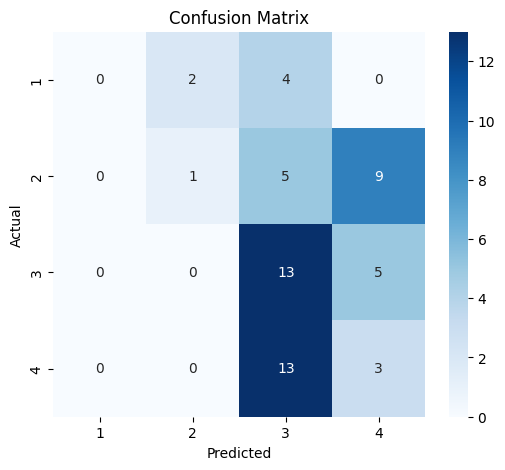

Accuracy: 0.3090909090909091

Classification report:
              precision    recall  f1-score   support

           1      0.000     0.000     0.000         6
           2      0.333     0.067     0.111        15
           3      0.371     0.722     0.491        18
           4      0.176     0.188     0.182        16

    accuracy                          0.309        55
   macro avg      0.220     0.244     0.196        55
weighted avg      0.264     0.309     0.244        55



c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

<Figure size 640x480 with 0 Axes>

In [ ]:
classes = np.unique(Y_test)

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred, labels=classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.savefig(os.path.join(figs_folder, 'classification_CM.png'))

# Accuracy and per-class metrics
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\nClassification report:")
print(classification_report(Y_test, y_pred, labels=classes, digits=3))


Severe bias toward classes 1 and 4.

Model does not predict classes 2 and 3 at all.

Poor generalization and possible imbalance in training data.

In [17]:
reference_df = joblib.load(REFERENCE_DATA_PATH)

numeric_cols = X_test.select_dtypes(include=[np.number]).columns

psi_results = {}
ks_results = {}

for col in numeric_cols:
    ref = reference_df[col].dropna()
    new = X_test[col].dropna()
    
    # PSI
    bins = pd.qcut(ref, q=10, duplicates="drop")
    ref_dist = bins.value_counts(normalize=True)
    new_bins = pd.cut(new, bins=bins.cat.categories)
    new_dist = new_bins.value_counts(normalize=True)
    
    # Align distributions to avoid NaNs
    ref_dist, new_dist = ref_dist.align(new_dist, fill_value=1e-6)
    
    psi = sum((new_dist - ref_dist) * np.log(new_dist / ref_dist))
    psi_results[col] = psi
    
    # KS
    ks_stat, ks_p = ks_2samp(ref, new)
    ks_results[col] = {"ks_stat": ks_stat, "p_value": ks_p}

drift_summary = pd.DataFrame({
    "Feature": psi_results.keys(),
    "PSI": psi_results.values(),
    "KS_Stat": [ks_results[col]["ks_stat"] for col in psi_results.keys()],
    "KS_p_value": [ks_results[col]["p_value"] for col in psi_results.keys()]
})

# Sort by PSI
drift_summary = drift_summary.sort_values(by="PSI", ascending=False)
print(drift_summary)

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


          Feature       PSI   KS_Stat  KS_p_value
1    Availability       inf  0.068608    0.967702
7         Latency       inf  0.099971    0.696514
6  Best Practices  0.209816  0.105266    0.635185
3  Successability  0.173325  0.141865    0.274106
4     Reliability  0.164928  0.106855    0.617173
9            WsRF  0.131468  0.080377    0.895927
2      Throughput  0.109543  0.107502    0.609265
8   Documentation  0.058942  0.066431    0.975905
0   Response Time  0.025915  0.072551    0.948942
5      Compliance       NaN  0.009885    1.000000


C:\Users\asaraiva\AppData\Local\Temp\ipykernel_23264\3148347258.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="PSI", y="Feature", data=drift_summary, palette="Blues_r")


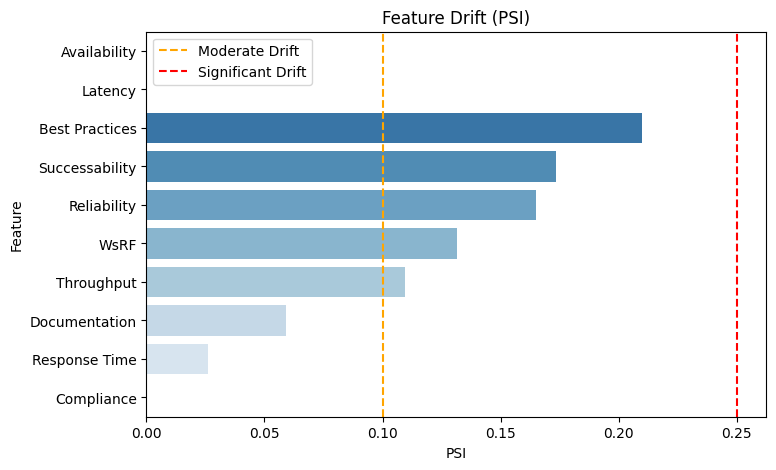

C:\Users\asaraiva\AppData\Local\Temp\ipykernel_23264\3148347258.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="KS_Stat", y="Feature", data=drift_summary, palette="Greens_r")


<Figure size 640x480 with 0 Axes>

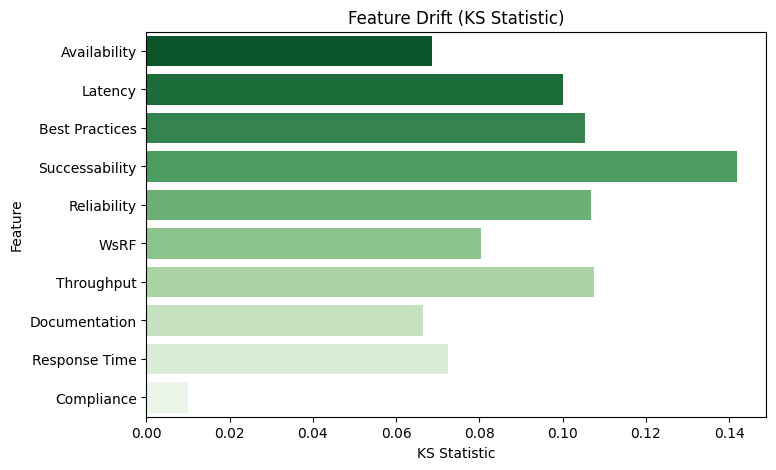

<Figure size 640x480 with 0 Axes>

In [18]:
# Add interpretation column
def classify_psi(psi):
    if psi < 0.1:
        return "No Drift"
    elif psi < 0.25:
        return "Moderate Drift"
    else:
        return "Significant Drift"

drift_summary["Drift_Level"] = drift_summary["PSI"].fillna(0).apply(classify_psi)

# PSI Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x="PSI", y="Feature", data=drift_summary, palette="Blues_r")
plt.axvline(0.1, color="orange", linestyle="--", label="Moderate Drift")
plt.axvline(0.25, color="red", linestyle="--", label="Significant Drift")
plt.title("Feature Drift (PSI)")
plt.xlabel("PSI")
plt.ylabel("Feature")
plt.legend()
plt.show()

plt.savefig(os.path.join(figs_folder, 'classification_PSI.png'))

# KS Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x="KS_Stat", y="Feature", data=drift_summary, palette="Greens_r")
plt.title("Feature Drift (KS Statistic)")
plt.xlabel("KS Statistic")
plt.ylabel("Feature")
plt.show()

plt.savefig(os.path.join(figs_folder, 'classification_KS.png'))

In [19]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming Y_test (true labels) and y_prob (predicted probabilities) exist
classes = np.unique(Y_test)

# --- ROC Curves ---
plt.figure(figsize=(7, 6))
for idx, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(Y_test == cls, y_prob[:, idx])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# --- Precision-Recall Curves ---
plt.figure(figsize=(7, 6))
for idx, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(Y_test == cls, y_prob[:, idx])
    plt.plot(recall, precision, label=f'Class {cls}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# --- Macro ROC AUC & PR AUC ---
roc_auc_macro = roc_auc_score(Y_test, y_prob, multi_class='ovr', average='macro')
pr_auc_macro = average_precision_score(Y_test, y_prob, average='macro')
print(f"Macro ROC AUC: {roc_auc_macro:.3f}")
print(f"Macro PR AUC: {pr_auc_macro:.3f}")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 700x600 with 0 Axes>